# Voltage traces for different $I_{\rm app}$, slow inactivation changes for half the ${\rm Na}^+$ channels

Changes for half the ${\rm Na}^+$ channels: $p_{\rm mut}=0.5$

Slow inactivation changes: voltage dependence + kinetics

Model: Hu, version with slow inactivation. Defined [here](utils/models/hu_slow_inact/hu_slow_inact.py).


In [13]:
import utils.simu_helper as simu_helper
import utils.plot_helper as plot_helper

import copy
import matplotlib.pyplot as plt

In [14]:
run_simu = True

In [15]:
# model
model_name = "hu_slow_inact"
model = simu_helper.import_model(model_name)

# temporary initial condition
y_0 = [-60, 0.5, 0.5, 0.5, 0.5, 0.5]

# parameter sets to be compared
param_set_id_1 = "wt"
param_set_id_2 = "inact_shift_half_channels"
param_set_id_3 = "altered_inact_half_channels"

my_params_wt = model.params_default | getattr(model, f"params_{param_set_id_1}")
my_params_mut = model.params_default | getattr(model, f"params_{param_set_id_2}")
my_params_mut_2 = model.params_default | getattr(model, f"params_{param_set_id_3}")

# values of applied current
i_app_vals = (35, 40, 45, 50, 55, 60)

t_start = 10000  # 10 second
t_end = 300000 + t_start  # in ms (2 minutes)

## 1) Simulations

### Prepare simulations

In [16]:
my_simu_wt = simu_helper.Simulation(model.rhs, my_params_wt, y_0, t_end, id=param_set_id_1)
my_simu_mut = simu_helper.Simulation(model.rhs, my_params_mut, y_0, t_end, id=param_set_id_2)
my_simu_mut_2 = simu_helper.Simulation(model.rhs, my_params_mut_2, y_0, t_end, id=param_set_id_3)

my_simu_mut.model_params["t_start"] = t_start
my_simu_wt.model_params["t_start"] = t_start
my_simu_mut_2.model_params["t_start"] = t_start

simu_all_wt = []
simu_all_mut = []
simu_all_mut_2 = []

### Find fixed point when there is no applied current

[-7.06196419e+01  8.67721692e-01  6.38884133e-01  1.78046109e-02
  7.36120521e-01  7.36120521e-01]
[-7.13232354e+01  8.77876972e-01  6.24872214e-01  1.69523263e-02
  7.47583225e-01  4.12948399e-01]
[-7.13297237e+01  8.77967434e-01  6.24741940e-01  1.69446523e-02
  7.47932131e-01  4.09301968e-01]


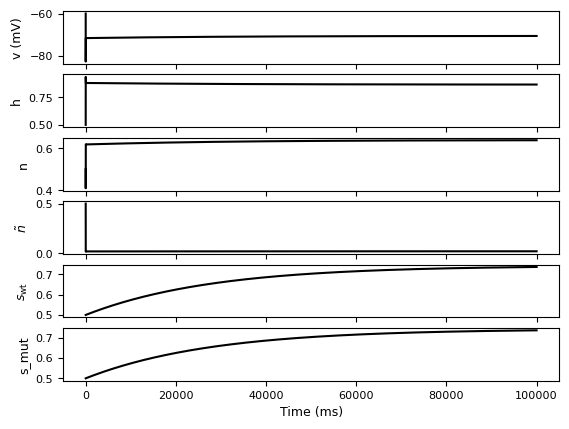

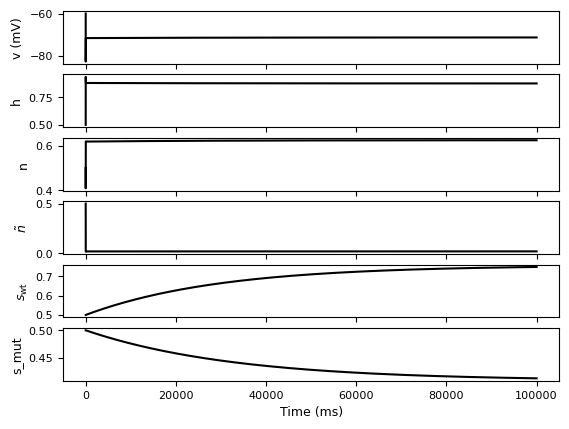

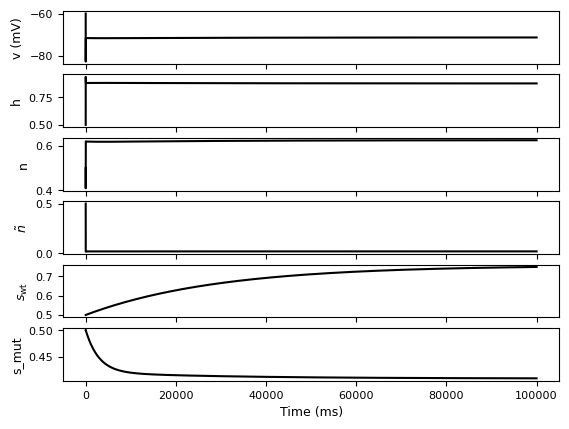

In [17]:
for my_simu in [my_simu_wt, my_simu_mut, my_simu_mut_2]:
    my_simu.model_params["i_input"] = 0
    my_simu.t_end = 100000
    my_simu.run()
    my_simu.plot_time_traces();
    y_0_rest_wt = my_simu.sol.y[:,-1]
    print(y_0_rest_wt)

    my_simu.y_0 = y_0_rest_wt
    my_simu.t_end = t_end


### Run or load simulations

In [18]:
accuracy_scaling = 1000000
for i_app in i_app_vals:
    print(f"i_app: {i_app}")
    # wild type
    my_simu_wt.model_params["i_app_step_val"] = i_app
    if run_simu:
        my_simu_wt.run(rtol=accuracy_scaling*1e-13, atol=accuracy_scaling*1e-19)
        my_simu_wt.save_sol(model_name, i_app)
    else:
        my_simu_wt.load_sol(model_name, i_app)
    simu_all_wt.append(copy.deepcopy(my_simu_wt))

    # mutation
    my_simu_mut.model_params["i_app_step_val"] = i_app
    if run_simu:
        my_simu_mut.run(rtol=accuracy_scaling*1e-13, atol=accuracy_scaling*1e-19)
        my_simu_mut.save_sol(model_name, i_app)
    else:
        my_simu_mut.load_sol(model_name, i_app)
    simu_all_mut.append(copy.deepcopy(my_simu_mut))


     # mutation 2
    my_simu_mut_2.model_params["i_app_step_val"] = i_app
    if run_simu:
        my_simu_mut_2.run(rtol=accuracy_scaling*1e-13, atol=accuracy_scaling*1e-19)
        my_simu_mut_2.save_sol(model_name, i_app)
    else:
        my_simu_mut_2.load_sol(model_name, i_app)
    simu_all_mut_2.append(copy.deepcopy(my_simu_mut_2))


i_app: 35
i_app: 40
i_app: 45
i_app: 50
i_app: 55
i_app: 60


## 2) Figure

The figure is here: figures/figure_4.eps


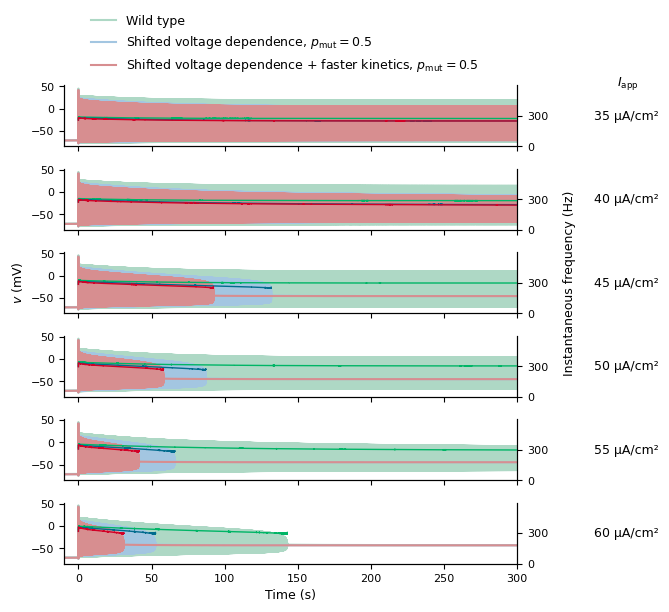

In [19]:
fig, axes = plt.subplots(len(i_app_vals), 1, sharex=True, sharey=True)
fig.set_size_inches(plot_helper.fig_size_default["width"], 6.2)

color_wt = plot_helper.color_wt
color_wt_freq = plot_helper.color_wt_dark
color_mut = plot_helper.color_mut
color_mut_freq = plot_helper.color_mut_dark
color_mut_2 = plot_helper.color_mut_2
color_mut_freq_2 = plot_helper.color_mut_2_dark

for idx, i_app in enumerate(i_app_vals):
    # wt plot
    ax = axes[idx]
    simu_all_wt[idx].plot_voltage_trace(ax, unit="second", time_shift=10, color=color_wt, label="Wild type", zorder=-1)
    ax_freq = simu_all_wt[idx].plot_inst_freq(ax, time_shift=10, color=color_wt_freq)
    ax_freq.set_ylim([0, 600])
    ax_freq.set_yticks([0, 300])

    if idx==2:
        ax.set_ylabel("$v$ (mV)")
        ax_freq.set_ylabel("Instantaneous frequency (Hz)")
        ax_freq.yaxis.set_label_coords(x=1.1, y=0.5)

    # mut plot
    simu_all_mut[idx].plot_voltage_trace(ax, unit="second", time_shift=10, color=color_mut_2, label=r"Shifted voltage dependence, $p_{\rm mut}=0.5$")
    ax_freq = simu_all_mut[idx].plot_inst_freq(ax, ax_freq=ax_freq, time_shift=10, color=color_mut_freq_2)
    # mut 2 plot
    simu_all_mut_2[idx].plot_voltage_trace(ax, unit="second", time_shift=10, color=color_mut, label=r"Shifted voltage dependence + faster kinetics, $p_{\rm mut}=0.5$")
    ax_freq = simu_all_mut_2[idx].plot_inst_freq(ax, ax_freq=ax_freq, time_shift=10, color=color_mut_freq)
    
    plot_helper.annotate_blended(ax, f"{i_app}"+u" \u00B5A/cm\u00B2", [1.17, 0.5], rotation=0, va="center")


plot_helper.my_legend(axes[0], loc=[0.05, 1.1], fontsize=9)
plot_helper.annotate_blended(axes[0], r"$I_{\rm app}$", [1.22, 1], rotation=0)

axes[-1].set_xlabel("Time (s)")
axes[0].set_xlim([-10, 300])

    
# beautify
for ax in fig.axes:
    ax.spines[['top']].set_visible(False)

fig.tight_layout()

# save figure
fig_dir = plot_helper.fig_dir
fig_path = f'{fig_dir}/figure_4.eps'
print(f"The figure is here: {fig_path}")
plt.savefig(fig_path, format='eps')    